# 蠟燭線回測
### 初始資料拿取

In [2]:
import numpy as np
import pandas as pd
import talib
from talib import MACD
from scipy.signal import argrelextrema
import matplotlib as plt

%matplotlib inline

In [3]:
df = pd.read_csv('TXF\TXF.txt', sep=",")
df['DateTime'] = df.Date + ' ' + df.Time

In [4]:
prices = df.iloc[:100000,:].copy()

In [5]:
def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []

    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['High'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Low'].idxmin())  

    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
#     max_min = pd.concat([maxima, minima]).sort_index()
    maxima.index.name = 'date'
    minima.index.name = 'date'
    
    maxima = maxima.reset_index()
    maxima = maxima[~maxima.date.duplicated()]
    p = prices.reset_index()   
    maxima['day_num'] = p[p['index'].isin(maxima.date)].index.values
    maxima = maxima.set_index('day_num')['High']
    
    minima = minima.reset_index()
    minima = minima[~minima.date.duplicated()]  
    minima['day_num'] = p[p['index'].isin(minima.date)].index.values
    minima = minima.set_index('day_num')['Low']
    
    return maxima, minima

In [126]:
smoothing = 5
window = 20

maxima, minima = get_max_min(prices, smoothing, window)

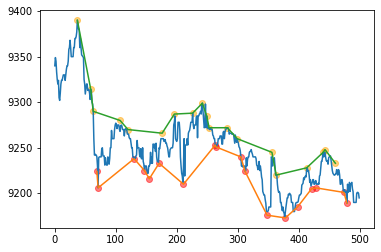

In [127]:
prices.reset_index()['Close'].plot()
plt.pyplot.scatter(maxima.index, maxima.values, color='orange', alpha=.5)
plt.pyplot.scatter(minima.index, minima.values, color='red', alpha=.5)

x = minima.index
y = minima.values
plt.pyplot.plot(x, y)

x = maxima.index
y = maxima.values
plt.pyplot.plot(x, y)

取include夜盤data,將100000切成20份，測試看看策略在哪個區間績效最差，找出差的原因

In [64]:
#initial
equity = 0
buy_point = 0
close_now = 0
exit_point = 0
earn = []
portion = 0
smoothing = 10
window = 40
target = 0
uptrend_limit = 0.5
uptrend_slope = 0.5
downtrend_limit = -0.5
downtrend_slope = -0.5
rest_counter = 0

buy_x = []
buy_y = []
stop_x = []
stop_y = []
target_x = []
target_y = []
price_list = []
price_index = []
minima_index_list = []
minima_price_list = []
maxima_index_list = []
maxima_price_list = []

slope = 0
whole = 2000
n= 1000
# test_prices = prices.iloc[n:n+100, :]
test_prices = prices.iloc[n:n+whole, :]
period = 10

for i, close_now in enumerate(test_prices.Close.values):
    price_list.append(close_now)
    price_index.append(i)
    close_index = 100 + i
    # print(f'iter : {i}, portion : {portion}')
    # i start from 100
    maxima,minima = get_max_min(prices.iloc[n-100+i:n+i, :], smoothing, window)
    #随著時間進行index每次會減1
    maxima.index = maxima.index + i
    minima.index = minima.index + i
    # print(f'maxima list : {maxima}\n minima list : {minima}.')
    # print(f'close now [close_now] ; target price [target) ; slope (slope)')
    # print('trend stop')
    #入場條件
    if portion == 0:
        if target == 0:
            if len(price_list) > period: 
                downtrend_price = max(price_list[-period:])
                # print(f'downtrend_price {downtrend_price}')
                downtrend_index = price_index[-period:][price_list[-period:].index(downtrend_price)] + 100
                maxima_now = downtrend_price
                maxima_now_index = downtrend_index    
                target = downtrend_price
                target_x.append(i)
                target_y.append(target)
                maxima_index_list.append(i)
                maxima_price_list.append(maxima_now) 
        else:
            try:
                maxima_diff = maxima_now - maxima.values[-1]
            # maxima_diff 長度還不夠
            except IndexError:
                maxima_diff = 10
            if maxima_diff > 20:
                maxima_now = maxima.values[-1]
                maxima_now_index = maxima.index[-1]
                maxima_index_list.append(i)
                maxima_price_list.append(maxima_now)
                slope = (maxima_now - downtrend_price)/(maxima_now_index - downtrend_index)
                if slope < downtrend_slope:
                    downtrend_slope = slope
                target = target + downtrend_slope
                # print(f'{target} = {target} + {downtrend_slope}')
                target_x.append(i)
                target_y.append(target)
            
            else:
                target = target + downtrend_slope
                target_x.append(i)
                target_y.append(target)
            if close_now > target:
                if rest_counter == 0:
                    portion = 1
                    buy_point = close_now
                    # print(f'buy at {buy_point}')
                    buy_x.append(i)
                    buy_y.append(close_now)
                    target = 0
                    uptrend_slope = 1
                else:
                    rest_counter -= 1
                    # print(rest_counter)

    #出場條件
    if portion == 1:
        if target == 0:
            if len(price_list) > period: 
                uptrend_price = min(price_list[-period:])
                uptrend_index = price_index[-period:][price_list[-period:].index(uptrend_price)] + 100
            else:
                uptrend_price = min(price_list)
                uptrend_index = price_list.index(uptrend_price) + 100
            minima_now = uptrend_price
            minima_now_index = uptrend_index     
            minima_index_list.append(i)
            minima_price_list.append(minima_now) 
            target = uptrend_price
        else:
            try:
                min_diff = minima.values[-1] - minima_now
            except IndexError:
                min_diff = -20
            if min_diff > -10 :
                minima_now = minima.values[-1]
                minima_now_index = minima.index[-1]  
                minima_index_list.append(i)
                minima_price_list.append(minima_now)        
                slope = (minima_now - uptrend_price)/(minima_now_index - uptrend_index)
                if slope > uptrend_slope:
                    uptrend_slope = slope
                # print(f'slope {uptrend_slope}')
                target = target + uptrend_slope
            else:
                target = target + uptrend_slope
                target_x.append(i)
                target_y.append(target)
        # target = target + uptrend_slope
        # target = uptrend_price + (close_index - uptrend_index)*uptrend_slope
        
        # target = uptrend_price 
        target_x.append(i)
        target_y.append(target)
        # 停損
        diff = close_now - buy_point
        
        # if 0 > diff > -10:
        #     continue

        if diff < -10:
            print(f'stop, sell at {close_now}, earn {diff}')
            earn.append(diff)
            portion = 0
            buy_point = 0
            stop_x.append(i)
            stop_y.append(close_now)
            target = 0
            downtrend_slope = -0.5
            # print('abs stop')

        if close_now < target:
            print(f'earn, sell at {close_now}, earn {diff}')
            earn.append(diff)
            portion = 0
            buy_point = 0
            stop_x.append(i)
            stop_y.append(close_now)
            target = 0
            downtrend_slope = -0.5

        if portion == 0:
            if len(stop_x) > 2:
                index_diff = stop_x[-1] - stop_x[-2]
                # print(f'{index_diff} = {stop_x[-1]} - {stop_x[-2]}')
                if index_diff < 10:
                    rest_counter = 50

ipykernel_launcher:123: RuntimeWarning: invalid value encountered in double_scalars
stop, sell at 9170.0, earn -20.0
stop, sell at 9070.0, earn -20.0
earn, sell at 9100.0, earn 5.0
stop, sell at 9139.0, earn -11.0
earn, sell at 9131.0, earn -6.0
stop, sell at 9161.0, earn -27.0
stop, sell at 9162.0, earn -18.0
stop, sell at 9032.0, earn -18.0
earn, sell at 9151.0, earn 92.0
stop, sell at 9168.0, earn -19.0
earn, sell at 9333.0, earn 93.0
stop, sell at 9325.0, earn -20.0
stop, sell at 9260.0, earn -15.0
stop, sell at 9261.0, earn -17.0
stop, sell at 9272.0, earn -16.0
earn, sell at 9210.0, earn -7.0
earn, sell at 9225.0, earn 6.0
earn, sell at 9365.0, earn 147.0
earn, sell at 9383.0, earn 8.0
stop, sell at 9369.0, earn -11.0
stop, sell at 9360.0, earn -17.0
ipykernel_launcher:123: RuntimeWarning: divide by zero encountered in double_scalars
earn, sell at 9455.0, earn 55.0
earn, sell at 9485.0, earn 26.0
stop, sell at 9431.0, earn -63.0


In [65]:
earn

[-20.0,
 -20.0,
 5.0,
 -11.0,
 -6.0,
 -27.0,
 -18.0,
 -18.0,
 92.0,
 -19.0,
 93.0,
 -20.0,
 -15.0,
 -17.0,
 -16.0,
 -7.0,
 6.0,
 147.0,
 8.0,
 -11.0,
 -17.0,
 55.0,
 26.0,
 -63.0]

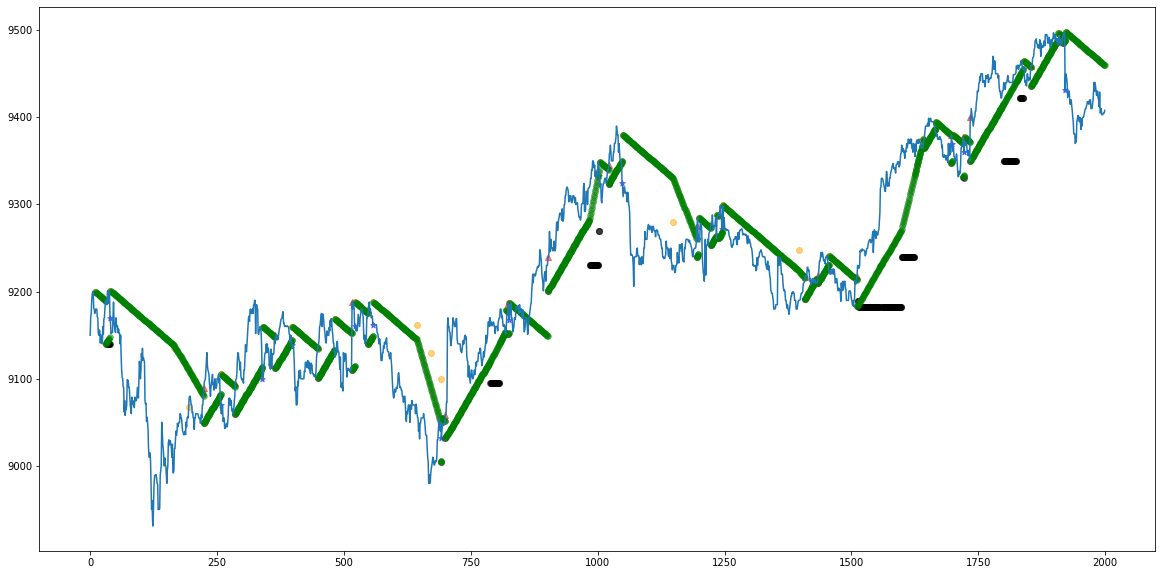

In [66]:
test_prices = prices.iloc[n:n+whole, :]
# smoothing = 1
# window = 5
# maxima, minima = get_max_min(test_prices, smoothing, window)
test_prices.reset_index()['Close'].plot()
plt.rcParams["figure.figsize"] = (20,10)
# plt.pyplot.scatter(maxima.index, maxima.values, color='orange', alpha=.5)
# plt.pyplot.scatter(minima.index, minima.values, color='black', alpha=.5)
plt.pyplot.scatter(maxima_index_list, maxima_price_list, color='orange', alpha=.5)
plt.pyplot.scatter(minima_index_list, minima_price_list, color='black', alpha=.5)
plt.pyplot.scatter(buy_x, buy_y, color='red', alpha=.5, marker = '^')
plt.pyplot.scatter(stop_x, stop_y, color='blue', alpha=.5, marker = '*')
plt.pyplot.scatter(target_x, target_y, color='green', alpha=.5, linewidths = 0.5)


In [67]:
print(f'avg {sum(earn)/len(earn)} ; total {sum(earn)} ; trade {len(earn)} times ; max(loss) : {min(earn)}')
print(f'all range : {price_list[-1] - price_list[0]}')

avg 5.291666666666667 ; total 127.0 ; trade 24 times ; max(loss) : -63.0
all range : 258.0


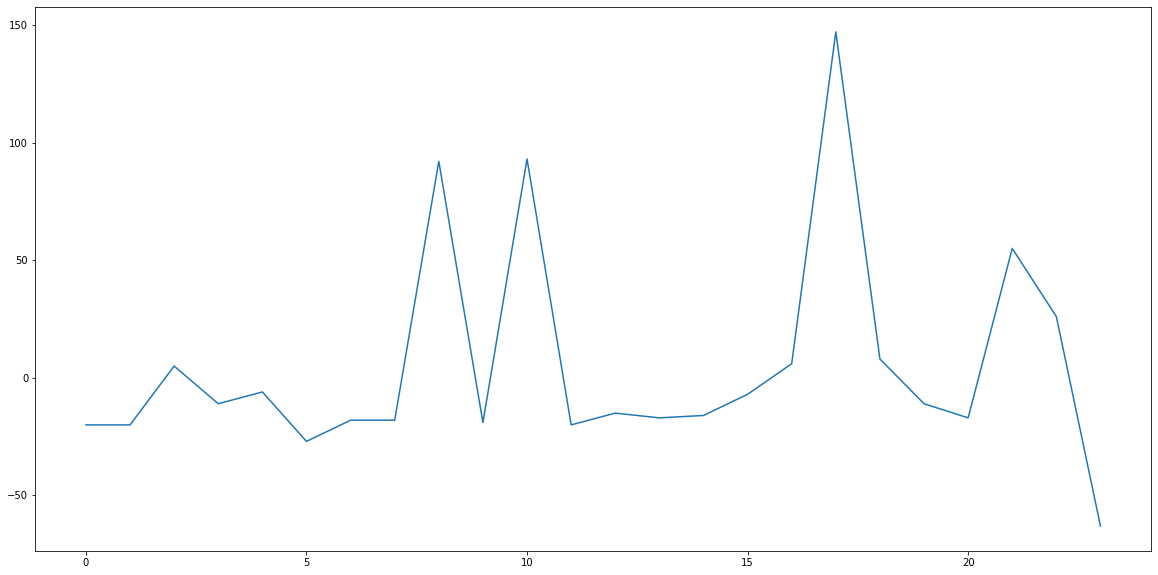

In [68]:
plt.pyplot.plot(earn)

In [135]:
accumu = 0
buy_point = 0
close_now = 0
exit_point = 0
earn = []
portion = 1
smoothing = 5
window = 20

maxima, minima = get_max_min(df.iloc[100+i:200+i, :], smoothing, window)

trend_index = []
trend_price = []
trend_index.append(minima.index[-1])
trend_price.append(minima.values[-1])

#initial
buy_point = prices.Close.values[0]
n = 200
for i, close in enumerate(prices.Close.values):
    diff = close - buy_point
    maxima, minima = get_max_min(df.iloc[n-100+i:n+i, :], smoothing, window)
    slope = (minima.values[-1] - trend_price[0])/( minima.index[-1] - trend_index[0] )
    if diff < -20:
        earn.append(diff)
        portion = 0
    
    if portion == 1:
        
        if minima.index[-1] != trend_index[0]:
            if minima.values[-1] > trend_price[0]:
                slope = (minima.values[-1] - trend_price[0])/( minima.index[-1] - trend_index[0] )
        target = minima.values[-1] + (n+i-minima.index[-1])*slope
        
        if close < target:
            diff = close - buy_point
            earn.append(diff)
            portion = 0
    
    if portion == 0:
        pass
        
        

C:\Users\Drey\anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [136]:
earn

[-35.0,
 -38.0,
 -30.0,
 -31.0,
 -25.0,
 -27.0,
 -26.0,
 -26.0,
 -30.0,
 -37.0,
 -26.0,
 -28.0,
 -40.0,
 -42.0,
 -50.0,
 -80.0,
 -98.0,
 -97.0,
 -98.0,
 -98.0,
 -100.0,
 -110.0,
 -134.0,
 -101.0,
 -100.0,
 -100.0,
 -100.0,
 -100.0,
 -91.0,
 -90.0,
 -99.0,
 -99.0,
 -99.0,
 -109.0,
 -101.0,
 -108.0,
 -109.0,
 -109.0,
 -100.0,
 -102.0,
 -108.0,
 -102.0,
 -90.0,
 -90.0,
 -71.0,
 -80.0,
 -80.0,
 -80.0,
 -80.0,
 -70.0,
 -65.0,
 -63.0,
 -65.0,
 -69.0,
 -65.0,
 -65.0,
 -65.0,
 -70.0,
 -72.0,
 -66.0,
 -65.0,
 -66.0,
 -70.0,
 -70.0,
 -70.0,
 -77.0,
 -70.0,
 -69.0,
 -70.0,
 -70.0,
 -75.0,
 -75.0,
 -75.0,
 -79.0,
 -80.0,
 -80.0,
 -85.0,
 -90.0,
 -90.0,
 -100.0,
 -100.0,
 -102.0,
 -101.0,
 -102.0,
 -99.0,
 -98.0,
 -82.0,
 -90.0,
 -90.0,
 -90.0,
 -98.0,
 -100.0,
 -91.0,
 -102.0,
 -102.0,
 -90.0,
 -105.0,
 -108.0,
 -115.0,
 -110.0,
 -110.0,
 -110.0,
 -115.0,
 -118.0,
 -118.0,
 -110.0,
 -110.0,
 -108.0,
 -95.0,
 -107.0,
 -100.0,
 -107.0,
 -86.0,
 -86.0,
 -90.0,
 -86.0,
 -94.0,
 -85.0,
 -100.0,
 -105.0

In [193]:
df['MA60'] = talib.SMA(df.Close, timeperiod=60)
df['MA20'] = talib.SMA(df.Close, timeperiod=20)

In [194]:
df['MACD'], df['MACDsignal'], macdhist = MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

In [195]:
df['Diff'] = df['Close'] - df['MA20']
df['MACD_Diff'] = df.MACD.diff()

In [196]:
# compute buy and sell signals (golden cross and death cross)
signal_long = (df.Diff > 0) & (df.MACD_Diff > 0)
signal_short = (df.MACD_Diff < 0)
# signal_long = (df.Close < df.MA20)
# signal_short = (df.Close > df.MA20)
# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

In [197]:
buy.tail()

4996    False
4997    False
4998     True
4999    False
5000    False
dtype: bool

In [198]:
close = df.Close
open_ = df.Open

### 計算買入時間

<AxesSubplot:>

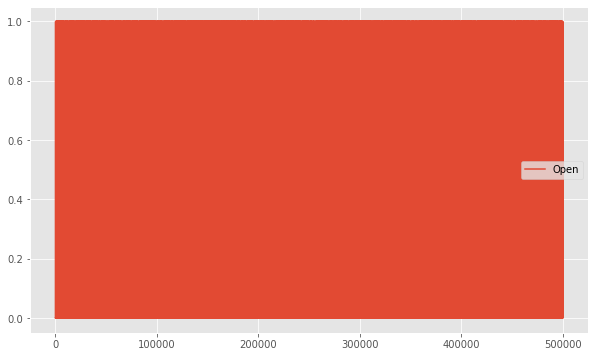

In [199]:
buy = (signal > 0)
sell = close < close.rolling(20).mean()
    
hold = pd.DataFrame(np.nan, index=close.index, columns=['Open'])
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.fillna(0, inplace=True)
hold = hold.shift()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

### 計算報酬率

In [200]:
import matplotlib.pyplot as plt

gain = (open_.shift(-1).ffill() / open_.ffill()).to_frame()

In [201]:
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()
# eq = gain[hold == 1]

<AxesSubplot:>

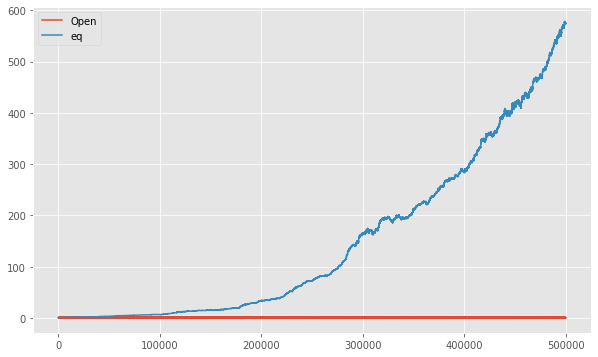

In [202]:
draw_df = hold.copy()
draw_df['eq'] = eq

draw_df.plot()

### 不要每天都rebalance

2.3126964791497087

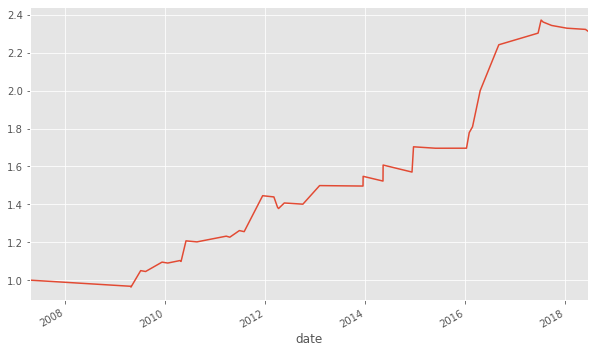

In [5]:
rebalance = (hold.diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0]
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

# 手續費
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff()
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().sum(axis=1)


eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod()
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [7]:
import pickle
pickle.dump(eq, open('return_history.pkl', 'wb'))